### (a) XOR (disyunción exclusiva)

Este problema encaja con la lógica proposicional del operador lógico XOR. Este operador sólo es Verdadero cuando ambas preposiciones son diferentes, por consiguiente es Falso cuando ambas preposiciones toman el mismo valor. La tabla de verdad para XOR es la siguiente:

|      A     |     B     |  A XOR B  |
|:----------:|:---------:|:---------:|
| Verdadero  | Verdadero |   Falso   |
|  Verdadero |   Falso   | Verdadero |
|    Falso   | Verdadero | Verdadero |
|    Falso   |   Falso   |   Falso   |

Entonces, A y B corresponden al par $x = (x_1, x_2) \in R^2$, con Falso < 0 y Verdadero > 0 y el operador XOR sobre A y B corresponde a $y = \in \{-1, 1\}$, siendo en este caso Falso = -1 y Verdadero = 1 obteniendo el problema no lineal deseado.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

def do_XOR(n=1000,noisy_n=100,svm=True):
    rng = np.random.RandomState(0)

    # Conjunto de entrenamiento
    X_train = rng.uniform(low=-1.0,high=1.0,size=(n,2))
    Y_train = np.logical_xor(X_train[:,0] > 0, X_train[:,1] > 0)
    Y_train = 2*Y_train-1 if svm else Y_train

    # Generación de ruido
    X_noisy= rng.uniform(low=-0.8,high=0.2,size=(noisy_n,2))
    Y_noisy = -1*np.logical_xor(X_noisy[:,0] > 0, X_noisy[:,1] > 0) + 1
    Y_noisy = 2*Y_noisy-1 if svm else Y_noisy
    
    # Se incorpora el ruido en el conjunto de entrenamiento
    X_train = np.vstack((X_train, X_noisy))
    Y_train = np.hstack((Y_train, Y_noisy))

    # Conjunto de prueba
    X_test = rng.uniform(low=-1.0,high=1.0,size=(n,2))
    Y_test = np.logical_xor(X_test[:,0] > 0, X_test[:,1] > 0)
    Y_test = 2*Y_test - 1 if svm else Y_test
    
    return X_train,Y_train,X_test,Y_test

X_train,Y_train,X_test,Y_test = do_XOR()

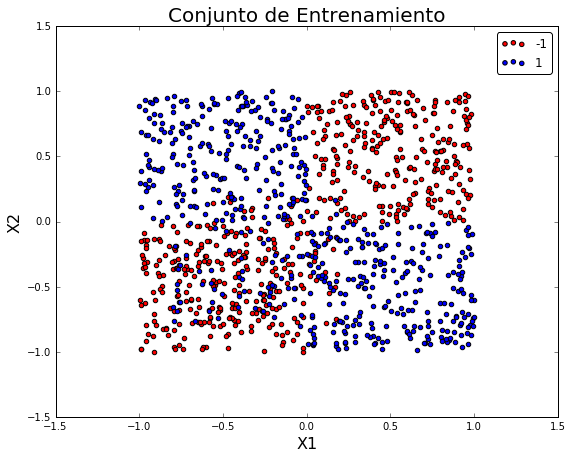

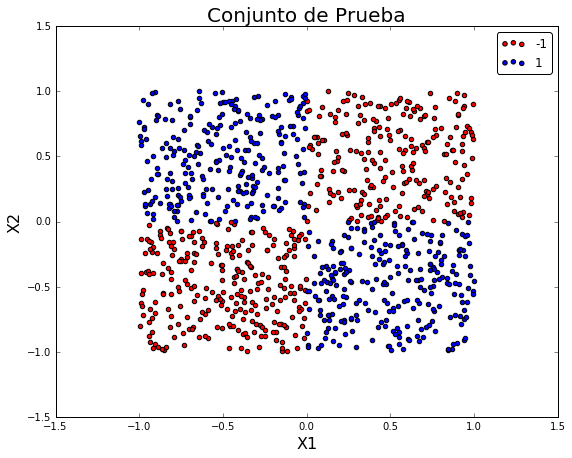

In [2]:
#import seaborn as sns
def plot_data(x, y, title):
    mclasses=(-1,1)
    mcolors = ['red', 'blue']
    plt.figure(figsize=(9, 7))

    for lab, col in zip(mclasses,mcolors):
        plt.scatter(x[y==lab, 0], x[y==lab, 1], label=lab, c=col)

    plt.title(title, fontsize = 20)
    plt.xlabel('X1', fontsize = 16)
    plt.ylabel('X2', fontsize = 16)
    leg = plt.legend(loc='upper right', fancybox=True)

    plt.show()

plot_data(X_train, Y_train, 'Conjunto de Entrenamiento')
plot_data(X_test, Y_test, 'Conjunto de Prueba')

### b) SVM-lineal

Primero se obtiene la probabilidad *a-priori* de cada clase.

In [3]:
prob_negativa = len(X_train[Y_train == -1]) / float(len(X_train[:,0]))
prob_positiva = len(X_train[Y_train == +1]) / float(len(X_train[:,0]))
print "Probabilidad de que un nuevo dato se clasifique en la clase -1: %f"% (prob_negativa)
print "Probabilidad de que un nuevo dato se clasifique en la clase +1: %f"% (prob_positiva)

Probabilidad de que un nuevo dato se clasifique en la clase -1: 0.500909
Probabilidad de que un nuevo dato se clasifique en la clase +1: 0.499091


Por lo que una mejora del $50\%$ significa que el clasificador obtenga un accuracy aproximado de un $75\%$.

In [84]:
#Funciones ocupadas para evaluar los algoritmos y graficar la clasificacion
from sklearn.metrics import classification_report
def score_the_model(model, x, y, xt, yt, text):
    acc_tr = model.score(x, y)
    acc_test = model.score(xt, yt)
    print "Training Accuracy %s: %f"%(text, acc_tr)
    print "Test Accuracy %s: %f"%(text, acc_test)
    print "Detailed Analysis Testing Results ..."
    print(classification_report(yt, model.predict(xt), target_names=['-1','+1']))
    
def plot_classifier(clf, X_train, Y_train, X_test,Y_test, model_type, title):
    f, axis = plt.subplots(1, 1, sharex='col', sharey='row',figsize=(10, 10))
    axis.scatter(X_train[:,0],X_train[:,1],s=5,c=Y_train,zorder=10,cmap='gray')
    axis.scatter(X_test[:,0],X_test[:,1],s=15,c=Y_test,zorder=10,cmap='gray')
    XX, YY = np.mgrid[-1:1:200j, -1:1:200j]
    if model_type == 'svm':
        Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])
    elif model_type == 'tree':
        Z = clf.predict_proba(np.c_[XX.ravel(), YY.ravel()])[:,0]
    elif model_type == 'ann':
        Z = clf.predict(np.c_[XX.ravel(), YY.ravel()])
    else: 
        raise ValueError('model type not supported')

    mcolor = plt.cm.Accent
    Z = Z.reshape(XX.shape)
    Zplot = Z > 0 if model_type == 'svm' else Z > 0.5
    #axis.pcolormesh(XX, YY, Zplot ,cmap='YlGn')
    axis.pcolormesh(XX, YY, Zplot ,cmap=mcolor)
    axis.contour(XX, YY, Z, alpha=1, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],levels=[-1, 0, 1])
    plt.title(title, fontsize = 18)

    plt.show()

In [5]:
from sklearn.svm import LinearSVC

def do_SVM_lineal(x,y,xt,yt,norm):
    Cs = np.logspace(-2, 3,base=10)
    acc_tr = []
    acc_test = []
    models = []
    for C in Cs:
        if(norm == 'l1'):
            model = LinearSVC(C=C, penalty=norm, dual=False)
        else:
            model = LinearSVC(C=C, penalty=norm)

        model = model.fit(x, y)
        acc_tr.append(model.score(x,y))
        acc_test.append(model.score(xt, yt))
        models.append(model)
    
    C_best = Cs[acc_test.index(max(acc_test))]
    model_best = models[acc_test.index(max(acc_test))]
    print "Mejor parámetro de regularización C: %s"%(C_best)
    print "Mejor Accuracy de Test: %f"%(max(acc_test))

    plt.figure(figsize=(10,5))
    ax = plt.gca()
    ax.plot(Cs,acc_tr,label='Accuracy train')
    ax.plot(Cs,acc_test,label='Accuracy test')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('C', fontsize= 16)
    plt.ylabel('Accuracy', fontsize= 16)
    plt.title('SVM Lineal con penalizacion %s'%(norm), fontsize= 20)
    ax.set_xscale('log')
    plt.show()
    
    return model_best, C_best

Mejor parámetro de regularización C: 0.104811313415
Mejor Accuracy de Test: 0.492000


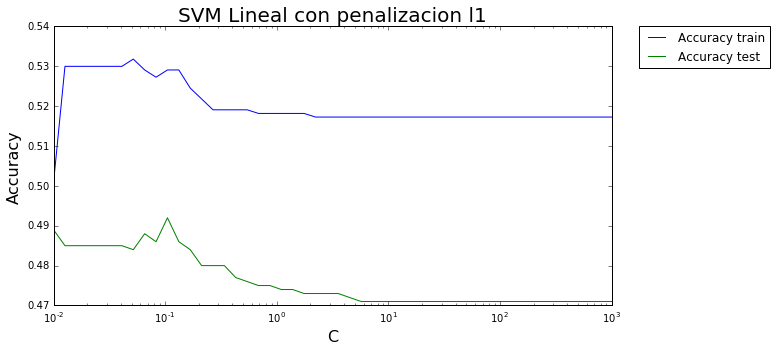

Mejor parámetro de regularización C: 308.884359648
Mejor Accuracy de Test: 0.587000


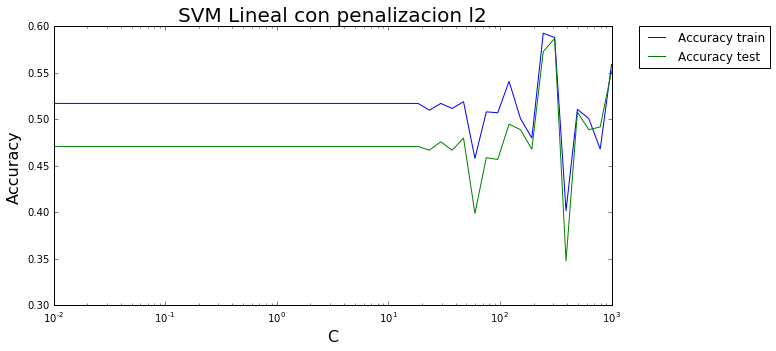

Training Accuracy SVM l1: 0.529091
Test Accuracy SVM l1: 0.492000
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

         -1       0.48      0.47      0.47       489
         +1       0.50      0.52      0.51       511

avg / total       0.49      0.49      0.49      1000

Training Accuracy SVM l2: 0.588182
Test Accuracy SVM l2: 0.587000
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

         -1       0.94      0.17      0.28       489
         +1       0.55      0.99      0.71       511

avg / total       0.74      0.59      0.50      1000



In [6]:
model1, C = do_SVM_lineal(X_train, Y_train, X_test, Y_test, 'l1')
model2, C = do_SVM_lineal(X_train, Y_train, X_test, Y_test, 'l2')

score_the_model(model1, X_train, Y_train, X_test, Y_test, "SVM l1")
score_the_model(model2, X_train, Y_train, X_test, Y_test, "SVM l2")

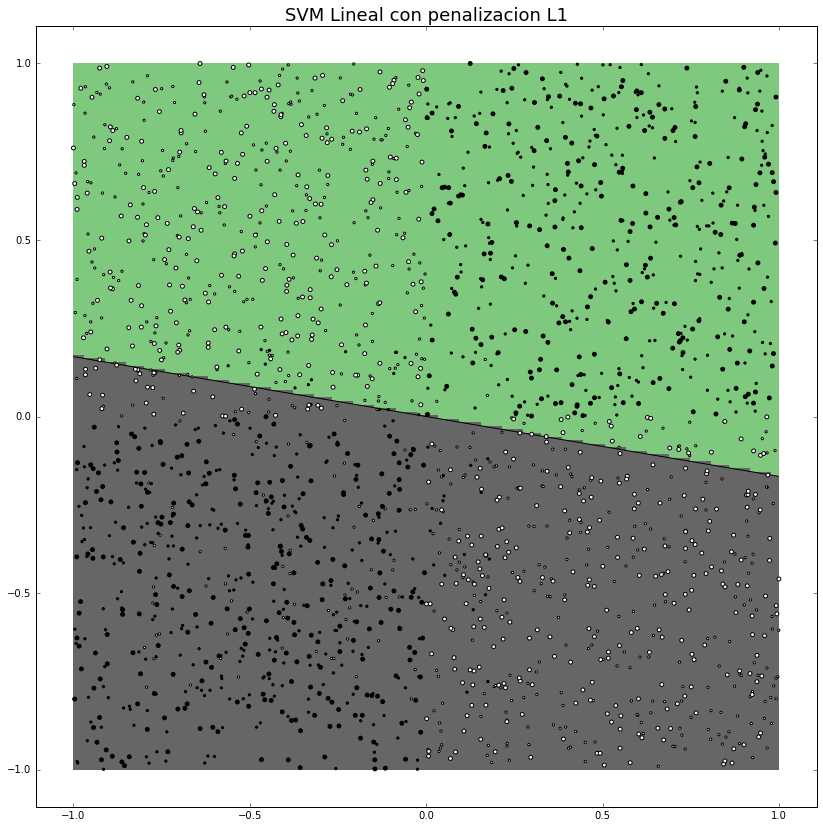

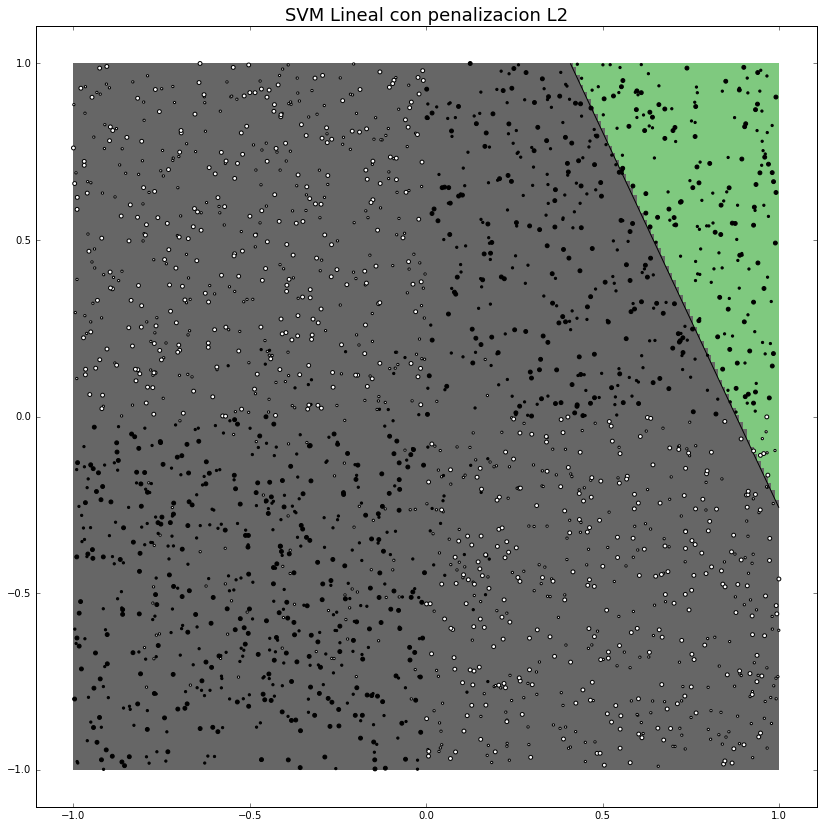

In [7]:
plot_classifier(model1,X_train,Y_train, X_test, Y_test, 'svm', 'SVM Lineal con penalizacion L1')
plot_classifier(model2,X_train,Y_train, X_test, Y_test, 'svm', 'SVM Lineal con penalizacion L2')

### (c) SVM no lineal

In [131]:
from sklearn.svm import SVC

def do_SVM_no_lineal(x,y,xt,yt,model_type):
    Cs = np.logspace(-2, 4,base=2, num=7)
    acc_tr = []
    acc_test = []
    models = []
    for C in Cs:
        if model_type == 'rbf':
            clf = SVC(C=C, kernel='rbf')
        elif model_type == 'poly':
            clf = SVC(C=C, kernel='poly',degree=2, coef0=1)

        clf.fit(X_train, Y_train)
        
        acc_tr.append(clf.score(x,y))
        acc_test.append(clf.score(xt, yt))
        models.append(clf)
    
    C_best = Cs[acc_test.index(max(acc_test))]
    model_best = models[acc_test.index(max(acc_test))]
    print "Mejor parámetro de regularización C: %s"%(C_best)
    print "Mejor Accuracy de Test: %f"%(max(acc_test))

    plt.figure(figsize=(10,5))
    ax = plt.gca()
    ax.plot(Cs,acc_tr,label='Accuracy train')
    ax.plot(Cs,acc_test,label='Accuracy test')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('C', fontsize= 16)
    plt.ylabel('Accuracy', fontsize= 16)
    plt.title('SVM no Lineal con kernel %s'%(model_type), fontsize= 20)
    ax.set_xscale('linear')
    plt.show()

    return model_best

Mejor parámetro de regularización C: 8.0
Mejor Accuracy de Test: 0.972000


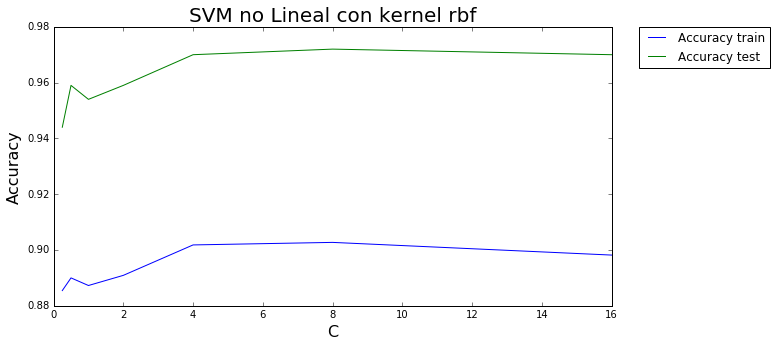

Mejor parámetro de regularización C: 8.0
Mejor Accuracy de Test: 0.955000


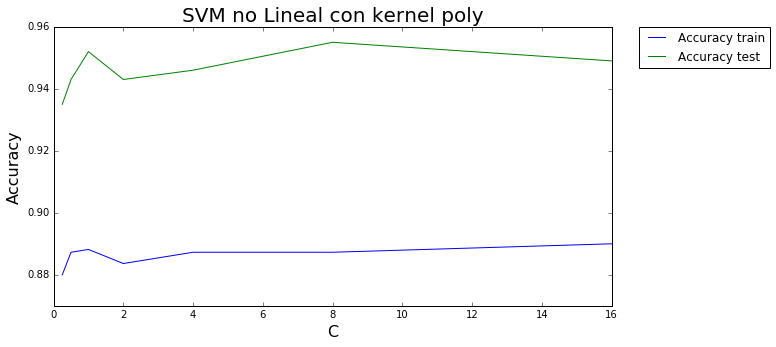

In [132]:
model_rbf = do_SVM_no_lineal(X_train, Y_train, X_test, Y_test, 'rbf')
model_poly = do_SVM_no_lineal(X_train, Y_train, X_test, Y_test, 'poly')

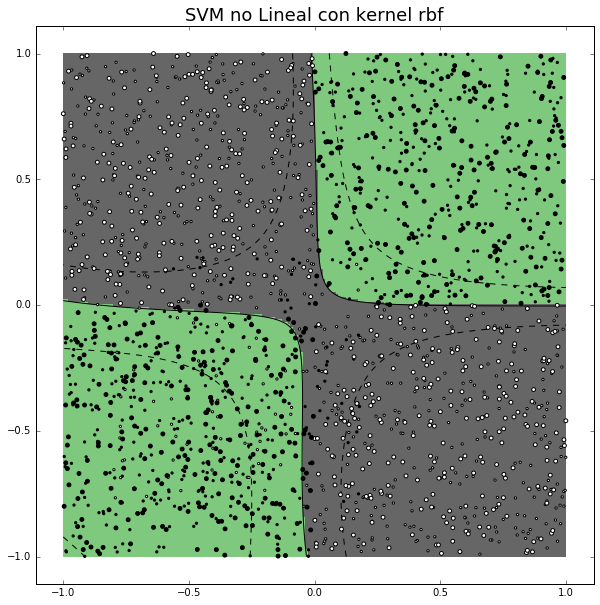

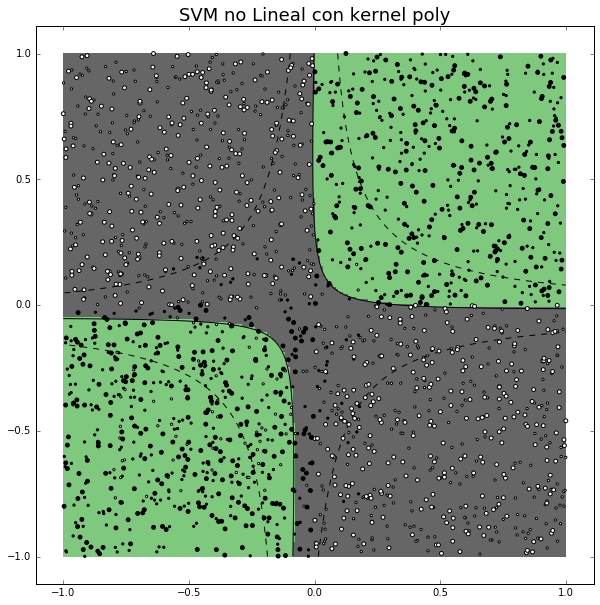

In [133]:
plot_classifier(model_rbf,X_train,Y_train, X_test, Y_test, 'svm', 'SVM no Lineal con kernel rbf')
plot_classifier(model_poly,X_train,Y_train, X_test, Y_test, 'svm', 'SVM no Lineal con kernel poly')

### (d) Red Neuronal con sólo 1 neurona

In [54]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

n_h=1
model = Sequential()

model.add(Dense(1, input_dim=X_train.shape[1], init='uniform', activation='relu'))
model.add(Dense(n_h, init='uniform', activation='sigmoid'))
model.compile(optimizer=SGD(lr=1), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, Y_train, nb_epoch=50, batch_size=100, verbose=1)
scores = model.evaluate(X_test, Y_test)
test_acc = scores[1]

Epoch 1/50
1100/1100 [==============================] - 0s - loss: 0.2462 - acc: 0.0218     
Epoch 2/50
1100/1100 [==============================] - 0s - loss: 0.0625 - acc: 0.0000e+00     
Epoch 3/50
1100/1100 [==============================] - 0s - loss: 0.0041 - acc: 0.0000e+00     
Epoch 4/50
1100/1100 [==============================] - 0s - loss: -0.1790 - acc: 0.0000e+00     
Epoch 5/50
1100/1100 [==============================] - 0s - loss: -0.9395 - acc: 0.0000e+00     
Epoch 6/50
1100/1100 [==============================] - 0s - loss: -1.3307 - acc: 0.0000e+00     
Epoch 7/50
1100/1100 [==============================] - 0s - loss: -1.5074 - acc: 0.0000e+00     
Epoch 8/50
1100/1100 [==============================] - 0s - loss: -1.5529 - acc: 0.0000e+00     
Epoch 9/50
1100/1100 [==============================] - 0s - loss: -1.5897 - acc: 0.0000e+00     
Epoch 10/50
1100/1100 [==============================] - 0s - loss: -1.5981 - acc: 0.0000e+00     
Epoch 11/50
1100/1100 [===

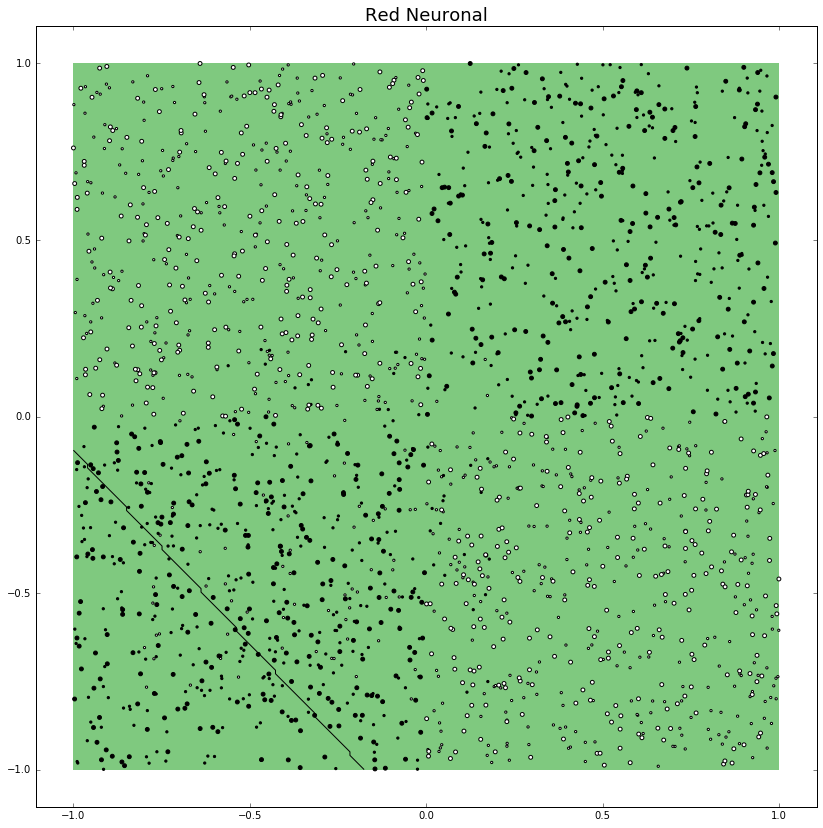

In [55]:
plot_classifier(model,X_train,Y_train, X_test, Y_test, 'ann', 'Red Neuronal')

### (e) Red Nueronal con 1 capa

In [ ]:
n_h=8
model = Sequential()
model.add(Dense(1, input_dim=X_train.shape[1], init='uniform', activation='relu'))
model.add(Dense(n_h, init='uniform', activation='sigmoid'))

#model.compile(optimizer=SGD(lr=1), loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer=SGD(lr=1), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, Y_train, nb_epoch=50, batch_size=100, verbose=1,class_weight=None, sample_weight=None)
scores = model.evaluate(X_test, Y_test)
test_acc = scores[1]

In [ ]:
plot_classifier(model,X_train,Y_train, X_test, Y_test, 'ann', 'Red Neuronal')

### (f) Árbol de Clasificación de 1 sólo nivel

Train Accuracy = 0.541818
Test Accuracy = 0.489000
Profundidad del arbol = 1


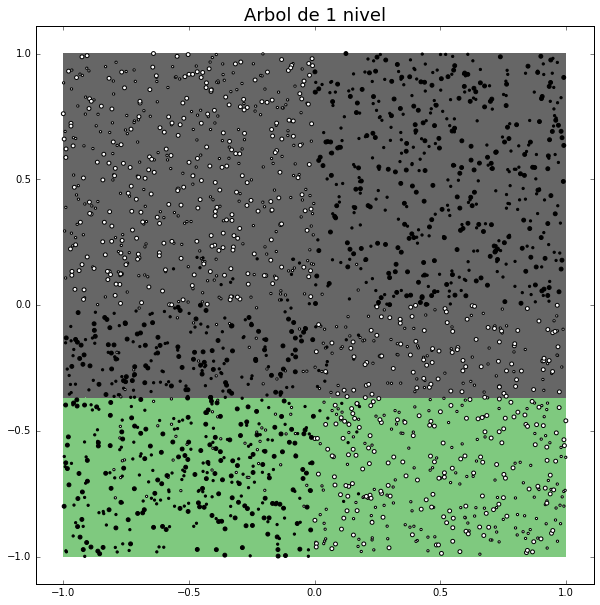

In [94]:
from sklearn.tree import DecisionTreeClassifier as Tree
n_t=1
clf=Tree(criterion='gini',splitter='best',random_state=0,max_depth=n_t) #entropy
clf.fit(X_train,Y_train)
acc_tr = clf.score(X_train, Y_train)
acc_test = clf.score(X_test,Y_test)
print "Train Accuracy = %f"%acc_tr
print "Test Accuracy = %f"%acc_test
print "Profundidad del arbol = %d"%clf.tree_.max_depth
plot_classifier(clf,X_train,Y_train,X_test,Y_test,'tree', 'Arbol de 1 nivel')

#score_the_model(clf, X_train, Y_train, X_test, Y_test, 'Arbol')

### (g) Árbol de clasificación de múltiples niveles

In [126]:
def do_Tree(x,y,xt,yt):
    N_ts = np.linspace(2, 20, num=19)
    acc_tr = []
    acc_test = []
    models = []
    for n_t in N_ts:
        clf=Tree(criterion='gini',splitter='best',random_state=0,max_depth=n_t)
        clf.fit(X_train,Y_train)
        acc_tr.append(clf.score(x,y))
        acc_test.append(clf.score(xt, yt))
        models.append(clf)
    
    N_t_best = N_ts[acc_test.index(max(acc_test))]
    model_best = models[acc_test.index(max(acc_test))]
    print "Número de niveles ideal: %s"%(N_t_best)
    print "Mejor Accuracy de Test: %f"%(max(acc_test))

    plt.figure(figsize=(10,5))
    ax = plt.gca()
    ax.plot(N_ts,acc_tr,label='Accuracy train')
    ax.plot(N_ts,acc_test,label='Accuracy test')
   
    #plt.xlim(1.5, 20.5)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('N_t', fontsize= 16)
    plt.ylabel('Accuracy', fontsize= 16)
    plt.title('Arbol de clasificacion con multiples niveles', fontsize= 20)
    ax.set_xscale('linear')
    plt.show()

    return model_best

Número de niveles ideal: 3.0
Mejor Accuracy de Test: 0.990000


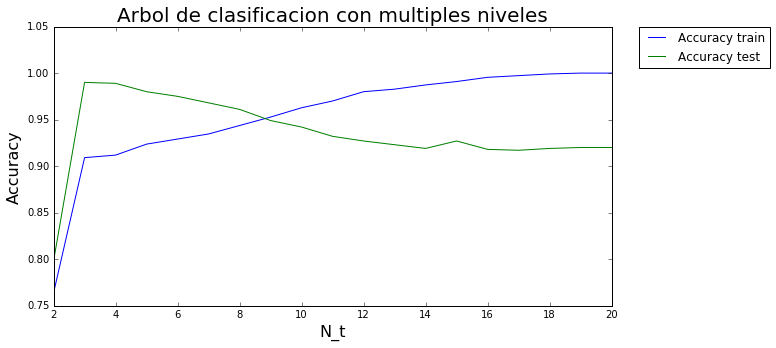

Training Accuracy Arbol Multiples Niveles: 0.909091
Test Accuracy Arbol Multiples Niveles: 0.990000
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

         -1       0.99      0.99      0.99       489
         +1       0.99      0.99      0.99       511

avg / total       0.99      0.99      0.99      1000



In [134]:
model_tree = do_Tree(X_train,Y_train,X_test,Y_test)

score_the_model(model_tree, X_train, Y_train, X_test, Y_test, "Arbol Multiples Niveles")

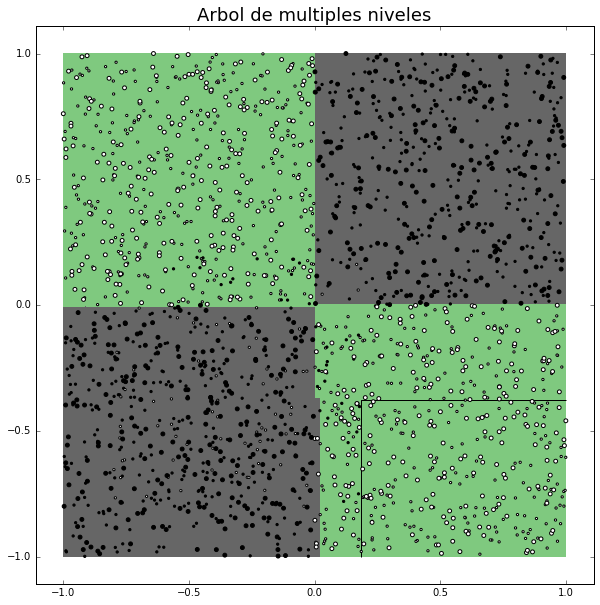

In [135]:
plot_classifier(model_tree,X_train,Y_train,X_test,Y_test,'tree', 'Arbol de multiples niveles')